In [1]:
import os
# os.chdir(r'C:数据集\house-prices-advanced-regression-techniques')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='muted')
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

In [2]:
# 导入数据集
train = pd.read_csv('/Users/chixinning/Desktop/kaggle/KaggleMyOwn/ReferenceCode/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/chixinning/Desktop/kaggle/KaggleMyOwn/ReferenceCode/house-prices-advanced-regression-techniques/test.csv')

# 保存Id列，并删除
train_id = train['Id']
test_id = test['Id']
train.drop(columns='Id', inplace=True)
test.drop(columns='Id', inplace=True)
print('删除ID列后的训练集大小：', train.shape)
print('删除ID列后的测试集大小：', test.shape)

# 合并训练集和测试集
all_data = pd.concat([train, test], axis=0, ignore_index=True)
# 保存标签列，并删除，方便数据清洗
sale_price = train['SalePrice']
all_data.drop(columns='SalePrice', inplace=True)

删除ID列后的训练集大小： (1460, 80)
删除ID列后的测试集大小： (1459, 79)


In [3]:
cols = train.columns
col_type = train.dtypes
excel = pd.DataFrame({'特征':cols, '数据类型':col_type})
excel.to_excel('特征描述.xlsx', index=False)

In [4]:
def calc_mis_val(df):
    cols = df.columns
    mis_val = df.isnull().sum()
    mis_val_pct = round(100 * mis_val / df.shape[0], 2)
    mis_val_df = pd.DataFrame({'mis_val':mis_val, 'mis_val_pct(%)':mis_val_pct}, index=cols)
    mis_val_df = mis_val_df[mis_val_df['mis_val'] != 0].sort_values('mis_val', ascending=False)
    print('总列数：', df.shape[1])
    print('含缺失值列数：', mis_val_df.shape[0])
    return mis_val_df

all_mis_val = calc_mis_val(all_data)


总列数： 79
含缺失值列数： 34


In [5]:
# 缺失值处理
def process_missing(df):
    # 根据特征描述， Functional的空值指的是‘Typ’
    df['Functional'] = df['Functional'].fillna('Typ')
    # 以下特征用众数替换
    df['Electrical'] = df['Electrical'].fillna("SBrkr")
    df['KitchenQual'] = df['KitchenQual'].fillna("TA")
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    # MSZoning和MSSubClass相关，用分组后的众数替代
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # 删除缺失值占比80%以上的特征
    df.drop(columns=['PoolQC','MiscFeature','Alley','Fence'])
    # 用0替代车库类的数值型特征
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    # 用None替代车库类的文本型特征
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[col] = df[col].fillna('None')
    # 用None替代地下室类的文本型特征 
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
        
    # LotFrontage与Neighborhood相关，用分组后的中位数替代
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # 剩余文本型特征的空值没有明确的意义，用None替代
    objects = []
    for i in df.columns:
        if df[i].dtype == object:
            objects.append(i)
    df.update(df[objects].fillna('None'))
        
    # 同样，对数值型特征，用0替代
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes:
            numeric.append(i)
    df.update(df[numeric].fillna(0))    
    return df

all_data = process_missing(all_data)


In [6]:
# 删除离群点
outlier1 = train[(train['OverallQual']==4) & (train['SalePrice']>200000)].index.tolist()
outlier2 = train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index.tolist()
outlier3 = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index.tolist()
outlier4 = train[(train['YearBuilt']<1900) & (train['SalePrice']>400000)].index.tolist()
outliers = outlier1 + outlier2 + outlier3 + outlier4
outliers = list(set(outliers))
print('离群点个数为{}，其索引为{}'.format(len(outliers), outliers))

# 特征矩阵以及标签都需要删除
all_data.drop(index=outliers, inplace=True)
sale_price.drop(index=outliers, inplace=True)

# 重置索引
all_data.reset_index(drop=True, inplace=True)
sale_price.reset_index(drop=True, inplace=True)

离群点个数为4，其索引为[185, 457, 1298, 523]


In [7]:
# 创造特征
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrSinceRemod'] = all_data['YrSold'].astype(int) - all_data['YearRemodAdd'].astype(int)
all_data['YrSinceBuilt'] = all_data['YrSold'].astype(int) - all_data['YearBuilt'].astype(int)
all_data['OverallEval'] = all_data['OverallQual'] + all_data['OverallCond']
all_data['LowQualPct'] = all_data['LowQualFinSF'] / all_data['TotalSF']
all_data['funcSF'] = all_data['WoodDeckSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] + all_data['PoolArea']

In [8]:
# 顺序特征编码
def order_coding(col):
    if col == 'Ex':
        code = 0
    elif col == 'Gd':
        code = 1
    elif col == 'TA':
        code = 2
    elif col == 'Fa':
        code = 3
    elif col == 'Po':
        code = 4
    else:
        code = 5
    return code

order_cols = ['BsmtCond','BsmtQual','ExterCond','ExterQual','FireplaceQu',
              'GarageCond','GarageQual','HeatingQC','KitchenQual']

# 为了防止被get_dummies独热编码，数据类型改为int
for order_col in order_cols:
    all_data[order_col] = all_data[order_col].apply(order_coding).astype(int)

In [9]:
# 一些数值型特征实际属于类别变量，修改其数据类型为文本型
all_data['MSSubClass'] = all_data['MSSubClass'].astype(object)
all_data['YrSold'] = all_data['YrSold'].astype(object)
all_data['MoSold'] = all_data['MoSold'].astype(object)

In [10]:
from sklearn.preprocessing import LabelEncoder
time_cols = ['GarageYrBlt','YearBuilt','YearRemodAdd','YrSold']
for time_col in time_cols:
    all_data[time_col] = LabelEncoder().fit_transform(all_data[time_col])

In [11]:
numeric_df = all_data.select_dtypes(['float64','int32','int64'])
numeric_cols = numeric_df.columns.tolist()

In [12]:
# 计算各数值型特征的偏度
skewed_cols = all_data[numeric_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_df = pd.DataFrame({'skew':skewed_cols})

In [13]:
# 对偏度绝对值大于0.5的特征进行对数变换
skew_cols = skewed_df[skewed_df['skew'].abs()>1].index.tolist()
for col in skew_cols:
    all_data[col] = np.log1p(all_data[col])

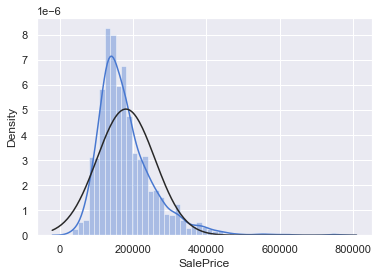

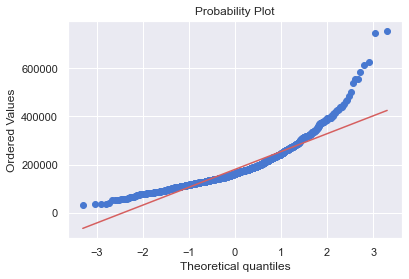

In [14]:
# SalePrice属于偏态分布
sns.distplot(sale_price, fit=norm)
fig = plt.figure()
res = stats.probplot(sale_price, plot=plt)

In [16]:
# 对其进行对数变换
sale_price = np.log1p(sale_price)

In [17]:
all_data = pd.get_dummies(all_data)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Columns: 297 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(30), int64(19), uint8(248)
memory usage: 1.8 MB


In [18]:
# 还原训练集和测试集
clean_train = all_data.iloc[:1456, :]
clean_test = all_data.iloc[1456:, :]

# 加上去除离群点后的标签列
clean_train = pd.concat([clean_train, sale_price], axis=1)

print('处理后的训练集大小：', clean_train.shape)
print('处理后的测试集大小：', clean_test.shape)

处理后的训练集大小： (1456, 298)
处理后的测试集大小： (1459, 297)


In [19]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [20]:
# 划分数据集
X = clean_train.drop(columns='SalePrice')
y = clean_train['SalePrice']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=10)

# 定义交叉验证模式
kf = KFold(n_splits=10, random_state=50, shuffle=True)

# 定义衡量指标函数
def rmse(y, y_pred):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return rmse

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
    return rmse

In [21]:
# 建立基线模型
lgb = LGBMRegressor(objective='regression', random_state=50)
xgb = XGBRegressor(objective='reg:linear', random_state=50, silent=True)
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kf))
svr = make_pipeline(RobustScaler(), SVR())
gbr = GradientBoostingRegressor(random_state=50)
rf = RandomForestRegressor(random_state=50)

# 基线模型评估
models = [lgb, xgb, ridge, svr, gbr, rf]
model_names = ['lgb','xgb','ridge','svr','gbr','rf']
scores = {}

for i, model in enumerate(models):
    score = cv_rmse(model)
    print('{} rmse score: {:.4f}, rmse std: {:.4f}'.format(model_names[i], score.mean(), score.std()))
    scores[model_names[i]] = (score.mean(), score.std())
    
rmse_df = pd.DataFrame(scores, index=['rmse_score','rmse_std'])
rmse_df.sort_values('rmse_score', axis=1, inplace=True)
rmse_df

lgb rmse score: 0.1251, rmse std: 0.0131
[11:54:21] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:54:22] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verific

,ridge,gbr,lgb,xgb,rf,svr
rmse_score,0.109154,0.122814,0.125095,0.125483,0.134361,0.135020
rmse_std,0.016739,0.012565,0.013054,0.016010,0.015219,0.022202


In [22]:
# 参数优化后的模型
lgb = LGBMRegressor(objeactive='regression'
                    ,n_estimators=1200
                    ,max_depth=8
                    ,num_leaves=10
                    ,min_data_in_leaf=3
                    ,max_bin=25
                    ,bagging_fraction=0.6
                    ,bagging_freq=11
                    ,feature_fraction=0.6
                    ,lambda_l1=0.004641588833612777
                    ,lambda_l2=4.641588833612782e-05
                    ,learning_rate=0.01
                    ,random_state=50
                    ,n_jobs=-1)

xgb = XGBRegressor(objective='reg:linear'
                   ,n_estimators=2550
                   ,learning_rate=0.02
                   ,max_depth=3
                   ,subsample=0.6
                   ,min_child_weight=3
                   ,colsample_bytree=0.5
                   ,random_state=50
                   ,n_jobs=-1
                   ,silent=True)

# ridge直接使用默认参数，效果反而更好
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kf))

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

gbr = GradientBoostingRegressor(n_estimators=6000
                                ,learning_rate=0.01
                                ,max_depth=4
                                ,max_features='sqrt'
                                ,min_samples_leaf=15
                                ,min_samples_split=10
                                ,loss='huber'
                                ,random_state=50)

rf = RandomForestRegressor(n_estimators=2000
                           ,max_depth=15
                           ,random_state=50
                           ,n_jobs=-1)

In [31]:
# 参数优化后的模型评估
models = [lgb, xgb, ridge, svr, gbr]
model_names = ['lgb','xgb','ridge','svr','gbr']
scores = {}

for i, model in enumerate(models):
    score = cv_rmse(model)
    print('{} rmse score: {:.4f}, rmse std: {:.4f}'.format(model_names[i], score.mean(), score.std()))
    scores[model_names[i]] = (score.mean(), score.std())
    
rmse_df = pd.DataFrame(scores, index=['rmse_score','rmse_std'])
rmse_df.sort_values('rmse_score', axis=1, inplace=True)
rmse_df


[LightGBM] [Warning] Unknown parameter: objeactive
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=4.641588833612782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.641588833612782e-05
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] lambda_l1 is set=0.004641588833612777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004641588833612777
[LightGBM] [Warning] Unknown parameter: objeactive
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is

,svr,ridge,xgb,gbr,lgb
rmse_score,0.107749,0.109154,0.111107,0.111982,0.112863
rmse_std,0.016873,0.016739,0.016376,0.016790,0.013173


In [ ]:
ridge.predict()

In [32]:
# 定义StackingRegressor类
class StackingRegressor(object):
    
    def __init__(self, fir_models, fir_model_names, sec_model, cv):
        # 第一层的基模型
        self.fir_models = fir_models
        self.fir_model_names = fir_model_names
        # 第二层用来预测结果的模型
        self.sec_model = sec_model
        # 交叉验证模式，必须为k_fold对象
        self.cv = cv
    
    def fit_predict(self, X, y, test):    # X,y,test必须为DataFrame
        # 创建空DataFrame
        stacked_train = pd.DataFrame()
        stacked_test = pd.DataFrame()
        # 初始化折数
        n_fold = 0

        # 遍历每个模型，做交叉验证
        for i, model in enumerate(self.fir_models):
            # 初始化stacked_train
            stacked_train[self.fir_model_names[i]] = np.zeros(shape=(X.shape[0], ))

            #遍历每一折交叉验证
            for train_index, valid_index in self.cv.split(X):
                # 初始化stacked_test
                n_fold += 1
                stacked_test[(self.fir_model_names[i], n_fold)] = np.zeros(shape=(test.shape[0], ))

                # 划分数据集
                X_train, y_train = X.iloc[train_index, :], y.iloc[train_index]
                X_valid, y_valid = X.iloc[valid_index, :], y.iloc[valid_index]

                # 训练模型并预测结果
                model.fit(X_train, y_train)
                stacked_train.loc[valid_index, self.fir_model_names[i]] = model.predict(X_valid)
                stacked_test.loc[:, (self.fir_model_names[i], n_fold)] = model.predict(test)
            print('{} is done.'.format(self.fir_model_names[i]))

        # stacked_train加上真实值标签
        y.reset_index(drop=True, inplace=True)
        stacked_train['y_true'] = y

        # 计算stacked_test中每个模型预测结果的平均值
        for i, model_name in enumerate(self.fir_model_names):
            stacked_test[model_name] = stacked_test.iloc[:, :10].mean(axis=1)
            stacked_test.drop(stacked_test.iloc[:, :10], axis=1, inplace=True)
        
        # 打印stacked_train和stacked_test
        print('----stacked_train----\n', stacked_train)
        print('----stacked_test----\n', stacked_test)
        
        # 用sec_model预测结果
        self.sec_model.fit(stacked_train.drop(columns='y_true'), stacked_train['y_true'])
        y_pred = self.sec_model.predict(stacked_test)
        return y_pred

In [33]:
sr = StackingRegressor(models, model_names, xgb, kf)
stacking_pred = sr.fit_predict(Xtrain, ytrain, Xtest)

[LightGBM] [Warning] Unknown parameter: objeactive
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=4.641588833612782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.641588833612782e-05
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] lambda_l1 is set=0.004641588833612777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004641588833612777


ValueError: shape mismatch: value array of shape (437,) could not be broadcast to indexing result of shape (2,437)

In [ ]:
# stacking_score = rmse(ytest, stacking_pred)
# print(stacking_score)

In [29]:
# 模型融合：blending
def blending(X, y, test):
    lgb.fit(X, y)
    lgb_pred = lgb.predict(test)

    xgb.fit(X, y)
    xgb_pred = xgb.predict(test)
    
    ridge.fit(X, y)
    ridge_pred = ridge.predict(test)
    
    svr.fit(X, y)
    svr_pred = svr.predict(test)
    
    gbr.fit(X, y)
    gbr_pred = gbr.predict(test)
    
    rf.fit(X, y)
    rf_pred = rf.predict(test)
    
    sr = StackingRegressor(models, model_names, xgb, kf)
    sr_pred = sr.fit_predict(X, y, test)
    
    # 加权求和
    blended_pred = (0.05 * lgb_pred +
                    0.1 * xgb_pred +
                    0.2 * ridge_pred +
                    0.25 * svr_pred +
                    0.15 * gbr_pred +
                    0.05 * rf_pred +
                    0.2 * sr_pred)
    return blended_pred

In [30]:
blended_pred = blending(Xtrain, ytrain, Xtest)
blending_score = rmse(ytest, blended_pred)
print(blending_score)

[LightGBM] [Warning] Unknown parameter: objeactive
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=4.641588833612782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.641588833612782e-05
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] lambda_l1 is set=0.004641588833612777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004641588833612777
[12:14:29] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:29] WARNING: /Users/travis/build/dmlc/xgboost

ValueError: shape mismatch: value array of shape (437,) could not be broadcast to indexing result of shape (2,437)

In [ ]:
y_pred = np.exp(blending(X, y, clean_test)) - 1
sample = pd.read_csv('/Users/chixinning/Desktop/kaggle/KaggleMyOwn/ReferenceCode/house-prices-advanced-regression-techniques/sample_submission.csv')
sample['SalePrice'] = y_pred
sample.to_csv('result.csv', index=False)